In [22]:
import itertools

import yaml
import pandas as pd
import numpy as np
import sklearn.metrics
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import lab.metrics
import lab.analytics

In [23]:
def load_results():
    combinations = [
      (classifier, factor, suffix)
      for classifier in ["kfp", "dfnet"]
      for factor in ["buflo-reg-client", "buflo-creg-in", "buflo-creg-out",
                     "undefended", "defended", "tail-wait", "full-packet", "buflo",
                     "buflo-10", "buflo-20", "buflo-50", "buflo-100", "buflo-hsk-10", "buflo-hsk-20", "buflo-in", "buflo-out"
                    ]
      for suffix in ["", ".sim", ".filtered"]
    ]
    # combinations = [
    #   (classifier, factor, suffix)
    #   for classifier in ["kfp", "dfnet"]
    #   for factor in ["undefended", "defended", "tail-wait", "full-packet", "buflo", "buflo-reg-client"]
    #   for suffix in ["", ".sim", ".filtered"]
    #   if (factor, suffix) not in [("buflo", ".sim"), ("buflo-reg-client", ".sim"), ("undefended", ".sim")]
    # ]
    # combinations = [
    #     (classifier, factor, suffix)
    #     for classifier in ["kfp", "dfnet"]
    #     # for factor in ["buflo", "buflo-10", "buflo-20", "buflo-50", "buflo-100", "buflo-200", "buflo-1000"]
    #     # for factor in ["buflo-10", "buflo-20", "buflo-50", "buflo-100", "buflo-hsk-10", "buflo-hsk-20", "buflo-in", "buflo-out"]
    #     for suffix in ["", ".filtered"]
    #     if (factor, suffix) not in [("buflo", ".sim"), ("undefended", ".sim")]
    # ]
    
    frames = []
    used_combinations = []
    for classifier, factor, suffix in combinations:
        try:
            frames.append(pd.read_csv(f"../../results/debug/{factor}/predict{suffix}/{classifier}-0.csv", header=0))
            used_combinations.append((classifier, factor, suffix))
        except FileNotFoundError:
            continue
        
    return (pd.concat(frames, keys=used_combinations, names=["classifier", "factor", "suffix"])
            .fillna(0)
            .rename(columns=lambda c: int(c) if c != "y_true" else c)
           )#.drop(columns=[-1]))


data = load_results()
data

y_true        -1         0
classifier factor           suffix                                  
kfp        buflo-reg-client           0     -1.0  1.000000  0.000000
                                      1     -1.0  1.000000  0.000000
                                      2     -1.0  1.000000  0.000000
                                      3     -1.0  1.000000  0.000000
                                      4     -1.0  1.000000  0.000000
...                                          ...       ...       ...
dfnet      buflo-out        .filtered 35     0.0  0.345821  0.654179
                                      36     0.0  0.087800  0.912200
                                      37     0.0  0.319213  0.680787
                                      38     0.0  0.259486  0.740514
                                      39     0.0  0.399336  0.600664

[2800 rows x 3 columns]

In [24]:
data["y_pred"] = data.drop(columns="y_true").idxmax(axis=1)
data
data.groupby(["classifier", "factor", "suffix"]).apply(lambda data: sklearn.metrics.balanced_accuracy_score(data["y_true"], data["y_pred"]))

classifier  factor      suffix   
dfnet       buflo                    0.825
                        .filtered    0.850
            buflo-10                 0.900
                        .filtered    0.625
            buflo-100                0.775
                                     ...  
kfp         tail-wait                0.950
                        .filtered    0.925
                        .sim         0.625
            undefended               0.975
                        .filtered    1.000
Length: 70, dtype: float64

In [25]:
plot_data = data.groupby(["classifier", "factor", "suffix"]).apply(lambda x: pd.DataFrame(dict(zip(["precision", "recall"], sklearn.metrics.precision_recall_curve(x["y_true"], x.loc[:, 0], pos_label=0))))).reset_index()
plot_data

,classifier,factor,suffix,level_3,precision,recall
0,dfnet,buflo,,0,1.000000,1.00
1,dfnet,buflo,,1,1.000000,0.95
2,dfnet,buflo,,2,1.000000,0.90
3,dfnet,buflo,,3,1.000000,0.85
4,dfnet,buflo,,4,1.000000,0.80
...,...,...,...,...,...,...
764,kfp,tail-wait,.sim,2,1.000000,0.00
765,kfp,undefended,,0,0.952381,1.00
766,kfp,undefended,,1,1.000000,0.00
767,kfp,undefended,.filtered,0,1.000000,1.00


In [26]:
plot_data["suffix"] = plot_data["suffix"].replace({".sim": "simulated", "": "collected", ".filtered": "filtered"})
plot_data.columns = ["dataset" if x == "suffix" else x for x in plot_data.columns]

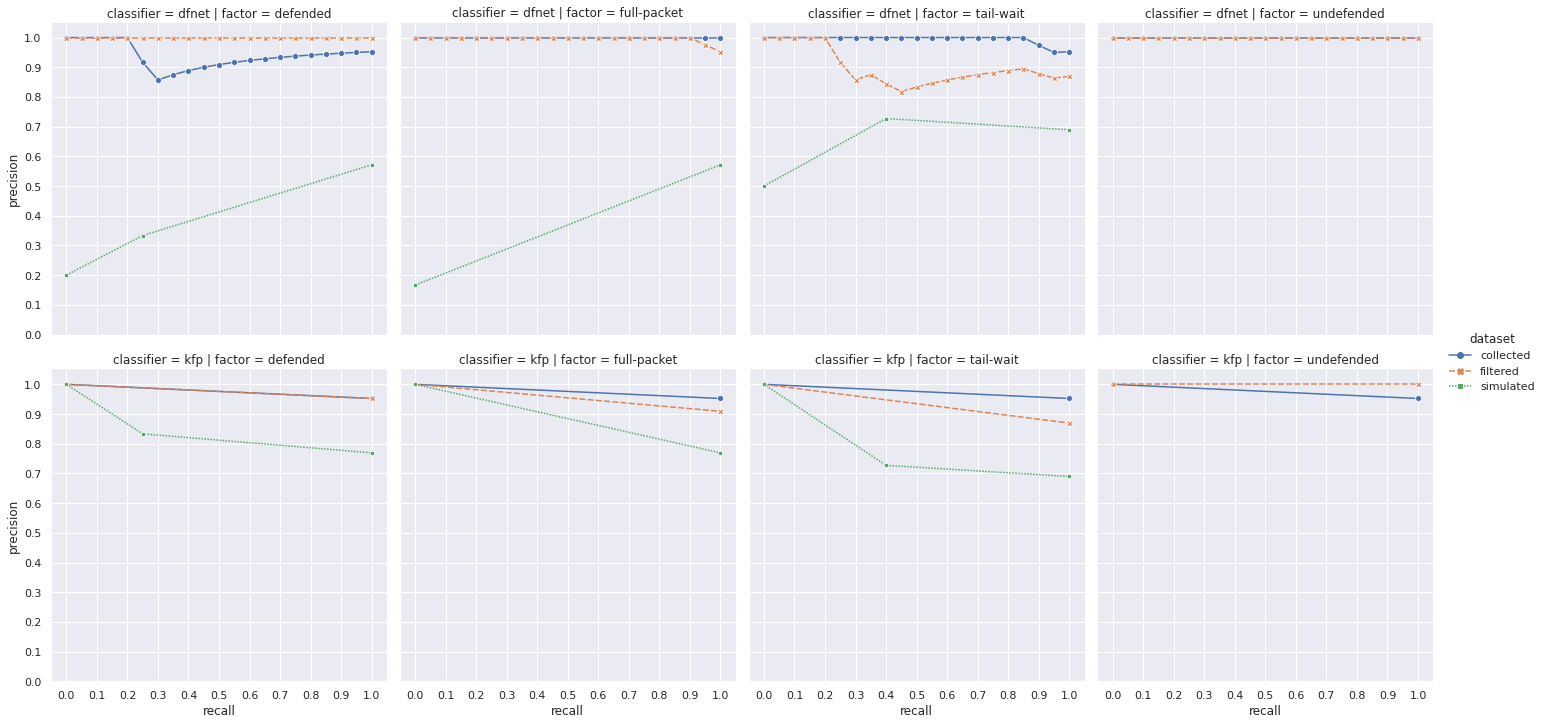

In [28]:
plot_data2 = plot_data[plot_data["factor"].isin(["undefended", "defended", "tail-wait", "full-packet"])]
sns.set()
fig = sns.relplot(data=plot_data2, x="recall", y="precision", hue="dataset", row="classifier", col="factor", kind="line", ci=None, markers=True, style="dataset",
                 
                 facet_kws=dict(subplot_kws=dict(ylim=(0, 1.05))))
_ = fig.axes[0][0].set_xticks(np.arange(0, 1.1, .1))
_ = fig.axes[0][0].set_yticks(np.arange(0, 1.1, .1))

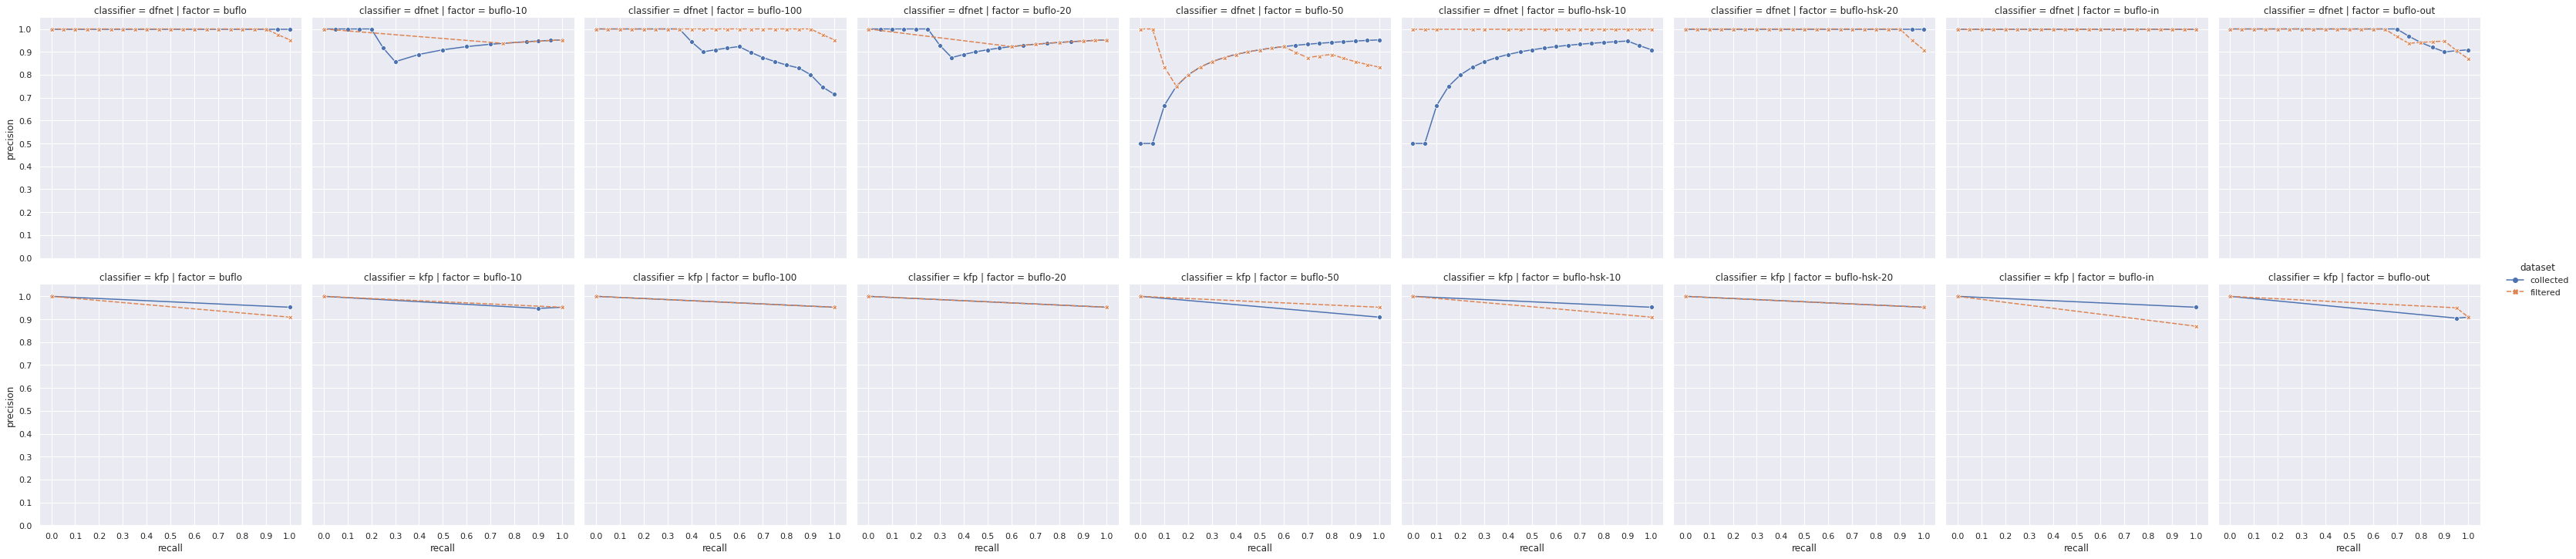

In [29]:
plot_data2 = plot_data[plot_data["factor"].isin([
    "buflo", "buflo-10", "buflo-20", "buflo-50", "buflo-100",
])]
sns.set()
fig = sns.relplot(data=plot_data2, x="recall", y="precision", hue="dataset", row="classifier", col="factor", kind="line", ci=None, markers=True, style="dataset",
                 
                 facet_kws=dict(subplot_kws=dict(ylim=(0, 1.05))))
_ = fig.axes[0][0].set_xticks(np.arange(0, 1.1, .1))
_ = fig.axes[0][0].set_yticks(np.arange(0, 1.1, .1))

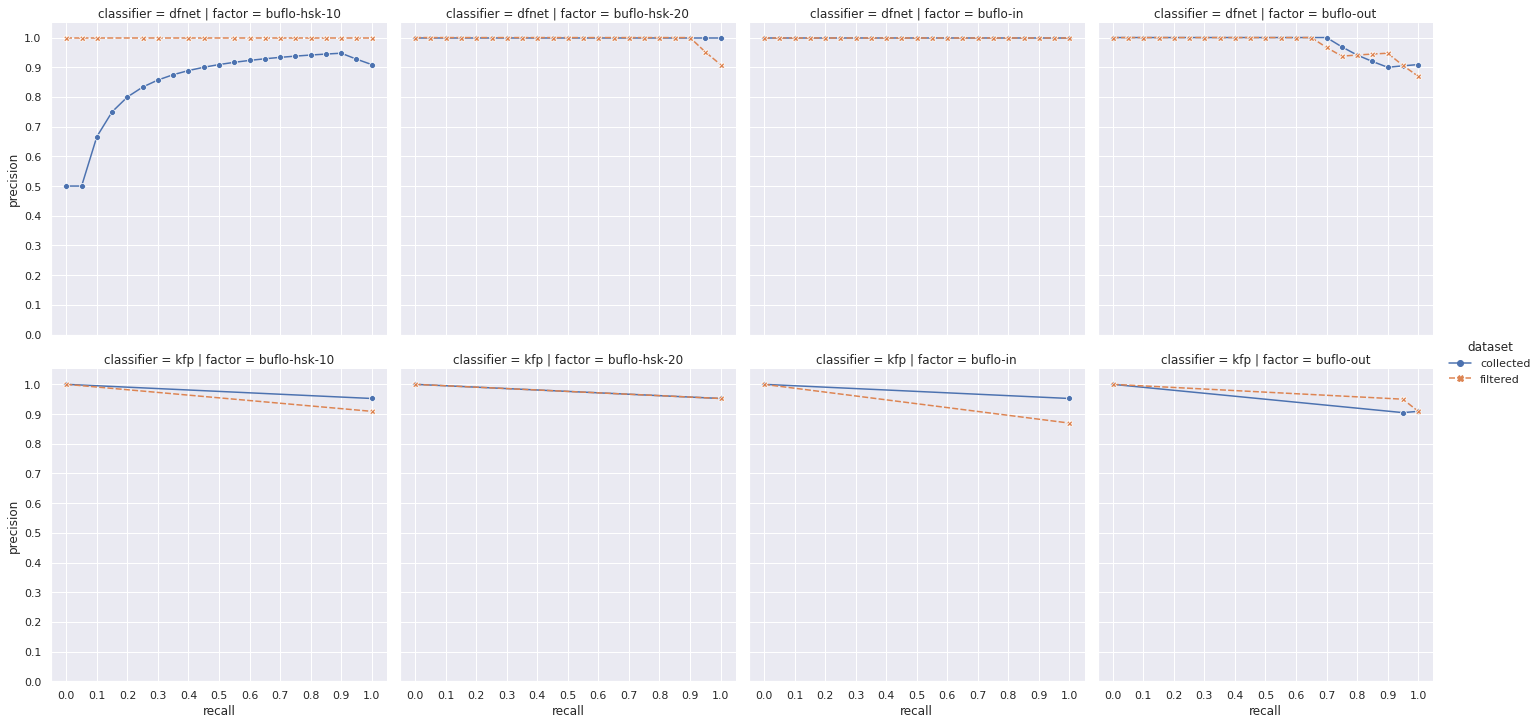

In [30]:
plot_data2 = plot_data[plot_data["factor"].isin([
     "buflo-hsk-10", "buflo-hsk-20", "buflo-in", "buflo-out"
])]
sns.set()
fig = sns.relplot(data=plot_data2, x="recall", y="precision", hue="dataset", row="classifier", col="factor", kind="line", ci=None, markers=True, style="dataset",
                 
                 facet_kws=dict(subplot_kws=dict(ylim=(0, 1.05))))
_ = fig.axes[0][0].set_xticks(np.arange(0, 1.1, .1))
_ = fig.axes[0][0].set_yticks(np.arange(0, 1.1, .1))

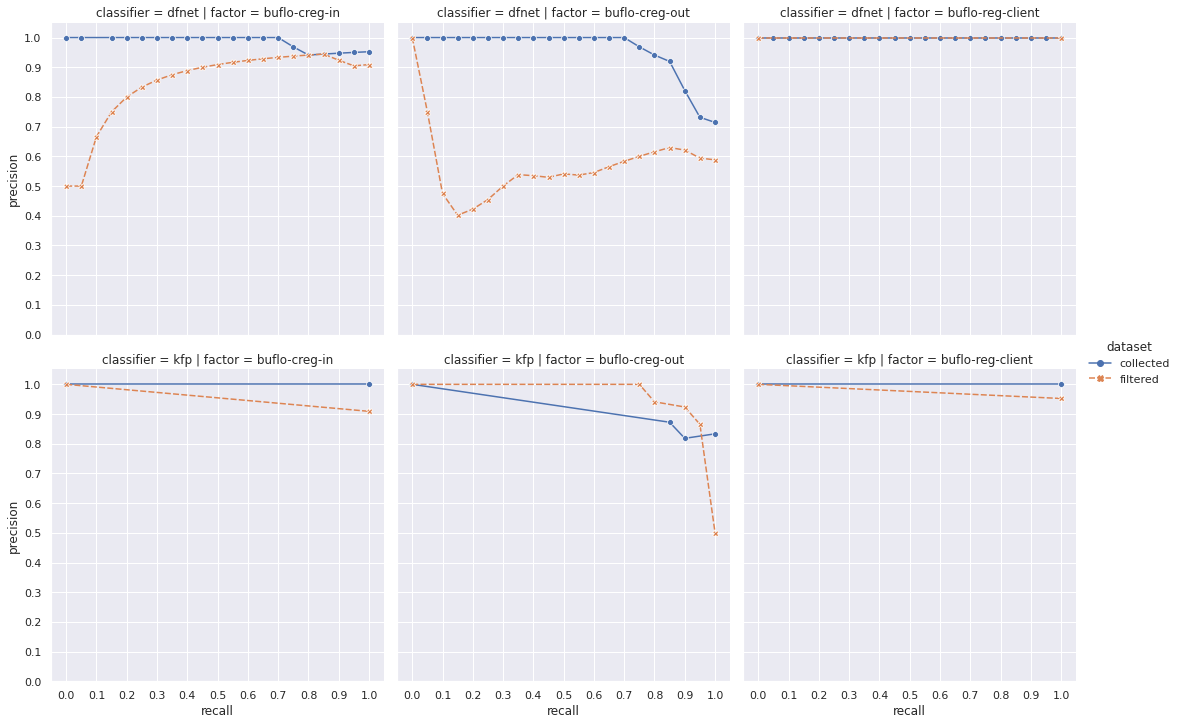

In [31]:
plot_data2 = plot_data[plot_data["factor"].isin([
    "buflo-reg-client", "buflo-creg-in", "buflo-creg-out",
])]
sns.set()
fig = sns.relplot(data=plot_data2, x="recall", y="precision", hue="dataset", row="classifier", col="factor", kind="line", ci=None, markers=True, style="dataset",
                 
                 facet_kws=dict(subplot_kws=dict(ylim=(0, 1.05))))
_ = fig.axes[0][0].set_xticks(np.arange(0, 1.1, .1))
_ = fig.axes[0][0].set_yticks(np.arange(0, 1.1, .1))

## buflo-x

In these cases, we removed all but the first $x$ packets of the connection, for the filtered and unfiltered scenarios. When dfnet was trained on only the first 50 packets, it suffered (surprisingly it did okay with only the first 10 packets when compared to the first 50, maybe the randomness affects it?). With a 100 packets, in the filtered scenario, it still performed well. 

k-fp by contrast was always able to perform well despite having only 10 packets. This is likely due to its usage of the of interarrival times.

## buflo-hsk-x

In this cases, we removed the first $x$ packets of each connection, for the filtered and unfiltered scenarios, corresponding to the handshake. Neither dfnet nor kfp were really affected by this. The unfiltered scenario for dfnet in buflo-hsk-10 seems to be an artifact of training.

## Conclusions

This is perhaps in part due to the dataset being small and an easy setting.